# NVIDIA NIMs

The `langchain-nvidia-ai-endpoints` package contains LangChain integrations building applications with models on
NVIDIA NIM inference microservice. NIM supports models across domains like chat, embedding, and re-ranking models
from the community as well as NVIDIA. These models are optimized by NVIDIA to deliver the best performance on NVIDIA
accelerated infrastructure and deployed as a NIM, an easy-to-use, prebuilt containers that deploy anywhere using a single
command on NVIDIA accelerated infrastructure.

NVIDIA hosted deployments of NIMs are available to test on the [NVIDIA API catalog](https://build.nvidia.com/). After testing,
NIMs can be exported from NVIDIA’s API catalog using the NVIDIA AI Enterprise license and run on-premises or in the cloud,
giving enterprises ownership and full control of their IP and AI application.

NIMs are packaged as container images on a per model basis and are distributed as NGC container images through the NVIDIA NGC Catalog.
At their core, NIMs provide easy, consistent, and familiar APIs for running inference on an AI model.

This example goes over how to use LangChain to interact with the supported [NVIDIA Retrieval QA Embedding Model](https://build.nvidia.com/nvidia/embed-qa-4) for [retrieval-augmented generation](https://developer.nvidia.com/blog/build-enterprise-retrieval-augmented-generation-apps-with-nvidia-retrieval-qa-embedding-model/) via the `NVIDIAEmbeddings` class.

For more information on accessing the chat models through this API, check out the [ChatNVIDIA](https://python.langchain.com/docs/integrations/chat/nvidia_ai_endpoints/) documentation.

## Installation

In [1]:
%pip install --upgrade --quiet  langchain-nvidia-ai-endpoints

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 972.1 kB/s eta 0:00:00


## Setup

**To get started:**

1. Create a free account with [NVIDIA](https://build.nvidia.com/), which hosts NVIDIA AI Foundation models.

2. Select the `Retrieval` tab, then select your model of choice.

3. Under `Input` select the `Python` tab, and click `Get API Key`. Then click `Generate Key`.

4. Copy and save the generated key as `NVIDIA_API_KEY`. From there, you should have access to the endpoints.

In [11]:
import getpass
import os

# del os.environ['NVIDIA_API_KEY']  ## delete key and reset
if os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    print("Valid NVIDIA_API_KEY already in environment. Delete to reset")
else:
    nvapi_key = getpass.getpass("NVAPI Key (starts with nvapi-): ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvapi_key



NVAPI Key (starts with nvapi-): ··········


We should be able to see an embedding model among that list which can be used in conjunction with an LLM for effective RAG solutions. We can interface with this model as well as other embedding models supported by NIM through the `NVIDIAEmbeddings` class.

## Working with NIMs on the NVIDIA API Catalog

When initializing an embedding model you can select a model by passing it, e.g. `NV-Embed-QA` below, or use the default by not passing any arguments.

In [21]:
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings

embedder = NVIDIAEmbeddings(model="nvdev/NV-Embed-QA")

ValueError: Model NVDEV/NV-Embed-QA is unknown, check `available_models`

This model is a fine-tuned E5-large model which supports the expected `Embeddings` methods including:

- `embed_query`: Generate query embedding for a query sample.

- `embed_documents`: Generate passage embeddings for a list of documents which you would like to search over.

- `aembed_query`/`aembed_documents`: Asynchronous versions of the above.

## Working with self-hosted NVIDIA NIMs
When ready to deploy, you can self-host models with NVIDIA NIM—which is included with the NVIDIA AI Enterprise software license—and run them anywhere, giving you ownership of your customizations and full control of your intellectual property (IP) and AI applications.

[Learn more about NIMs](https://developer.nvidia.com/blog/nvidia-nim-offers-optimized-inference-microservices-for-deploying-ai-models-at-scale/)


In [13]:
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings

# connect to an embedding NIM running at localhost:8080
embedder = NVIDIAEmbeddings(base_url="http://localhost:8080/v1")

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

### **Similarity**

The following is a quick test of the similarity for these data points:

**Queries:**

- What's the weather like in Komchatka?

- What kinds of food is Italy known for?

- What's my name? I bet you don't remember...

- What's the point of life anyways?

- The point of life is to have fun :D

**Documents:**

- Komchatka's weather is cold, with long, severe winters.

- Italy is famous for pasta, pizza, gelato, and espresso.

- I can't recall personal names, only provide information.

- Life's purpose varies, often seen as personal fulfillment.

- Enjoying life's moments is indeed a wonderful approach.

### Embedding Runtimes

In [14]:
print("\nSequential Embedding: ")
q_embeddings = [
    embedder.embed_query("What's the weather like in Komchatka?"),
    embedder.embed_query("What kinds of food is Italy known for?"),
    embedder.embed_query("What's my name? I bet you don't remember..."),
    embedder.embed_query("What's the point of life anyways?"),
    embedder.embed_query("The point of life is to have fun :D"),
]
print("Shape:", (len(q_embeddings), len(q_embeddings[0])))


Sequential Embedding: 
Shape: (5, 1024)


### Document Embedding

In [15]:
print("\nBatch Document Embedding: ")
d_embeddings = embedder.embed_documents(
    [
        "Komchatka's weather is cold, with long, severe winters.",
        "Italy is famous for pasta, pizza, gelato, and espresso.",
        "I can't recall personal names, only provide information.",
        "Life's purpose varies, often seen as personal fulfillment.",
        "Enjoying life's moments is indeed a wonderful approach.",
    ]
)
print("Shape:", (len(q_embeddings), len(q_embeddings[0])))


Batch Document Embedding: 
Shape: (5, 1024)


Now that we've generated our embeddings, we can do a simple similarity check on the results to see which documents would have triggered as reasonable answers in a retrieval task:

In [16]:
%pip install --upgrade --quiet  matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 43.6 MB/s eta 0:00:00


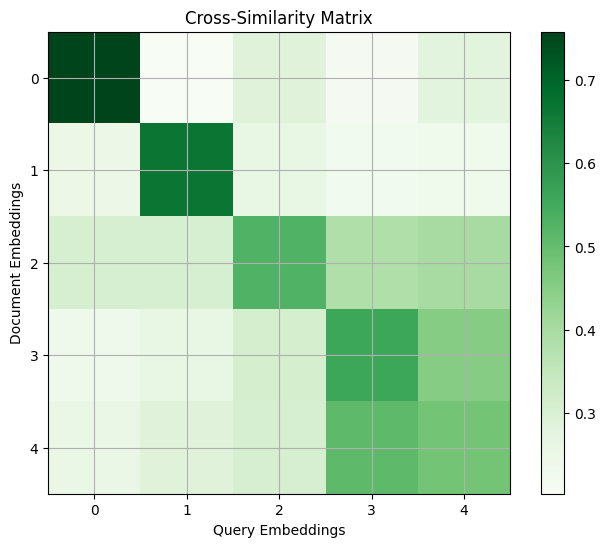

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Compute the similarity matrix between q_embeddings and d_embeddings
cross_similarity_matrix = cosine_similarity(
    np.array(q_embeddings),
    np.array(d_embeddings),
)

# Plotting the cross-similarity matrix
plt.figure(figsize=(8, 6))
plt.imshow(cross_similarity_matrix, cmap="Greens", interpolation="nearest")
plt.colorbar()
plt.title("Cross-Similarity Matrix")
plt.xlabel("Query Embeddings")
plt.ylabel("Document Embeddings")
plt.grid(True)
plt.show()

As a reminder, the queries and documents sent to our system were:

**Queries:**

- What's the weather like in Komchatka?

- What kinds of food is Italy known for?

- What's my name? I bet you don't remember...

- What's the point of life anyways?

- The point of life is to have fun :D

**Documents:**

- Komchatka's weather is cold, with long, severe winters.

- Italy is famous for pasta, pizza, gelato, and espresso.

- I can't recall personal names, only provide information.

- Life's purpose varies, often seen as personal fulfillment.

- Enjoying life's moments is indeed a wonderful approach.

## Truncation

Embedding models typically have a fixed context window that determines the maximum number of input tokens that can be embedded. This limit could be a hard limit, equal to the model's maximum input token length, or an effective limit, beyond which the accuracy of the embedding decreases.

Since models operate on tokens and applications usually work with text, it can be challenging for an application to ensure that its input stays within the model's token limits. By default, an exception is thrown if the input is too large.

To assist with this, NVIDIA's NIMs (API Catalog or local) provide a `truncate` parameter that truncates the input on the server side if it's too large.

The `truncate` parameter has three options:
 - "NONE": The default option. An exception is thrown if the input is too large.
 - "START": The server truncates the input from the start (left), discarding tokens as necessary.
 - "END": The server truncates the input from the end (right), discarding tokens as necessary.

In [18]:
long_text = "AI is amazing, amazing is " * 100

In [19]:
strict_embedder = NVIDIAEmbeddings()
try:
    strict_embedder.embed_query(long_text)
except Exception as e:
    print("Error:", e)

Error: [400] Bad Request
Input length 604 exceeds maximum allowed token size 512


In [20]:
truncating_embedder = NVIDIAEmbeddings(truncate="END")
truncating_embedder.embed_query(long_text)[:5]

[-0.017822265625,
 -0.00861358642578125,
 -0.042236328125,
 0.03985595703125,
 -0.0014667510986328125]

## RAG Retrieval:

The following is a repurposing of the initial example of the [LangChain Expression Language Retrieval Cookbook entry](
https://python.langchain.com/docs/expression_language/cookbook/retrieval), but executed with the AI Foundation Models' [Mixtral 8x7B Instruct](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/ai-foundation/models/mixtral-8x7b) and [NVIDIA Retrieval QA Embedding](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/ai-foundation/models/nvolve-40k) models available in their playground environments. The subsequent examples in the cookbook also run as expected, and we encourage you to explore with these options.

**TIP:** We would recommend using Mixtral for internal reasoning (i.e. instruction following for data extraction, tool selection, etc.) and Llama-Chat for a single final "wrap-up by making a simple response that works for this user based on the history and context" response.

In [ ]:
%pip install --upgrade --quiet  langchain faiss-cpu tiktoken langchain_community

from operator import itemgetter

from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_nvidia_ai_endpoints import ChatNVIDIA

In [ ]:
vectorstore = FAISS.from_texts(
    ["harrison worked at kensho"],
    embedding=NVIDIAEmbeddings(model="NV-Embed-QA"),
)
retriever = vectorstore.as_retriever()

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer solely based on the following context:\n<Documents>\n{context}\n</Documents>",
        ),
        ("user", "{question}"),
    ]
)

model = ChatNVIDIA(model="ai-mixtral-8x7b-instruct")

chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

chain.invoke("where did harrison work?")

In [ ]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer using information solely based on the following context:\n<Documents>\n{context}\n</Documents>"
            "\nSpeak only in the following language: {language}",
        ),
        ("user", "{question}"),
    ]
)

chain = (
    {
        "context": itemgetter("question") | retriever,
        "question": itemgetter("question"),
        "language": itemgetter("language"),
    }
    | prompt
    | model
    | StrOutputParser()
)

chain.invoke({"question": "where did harrison work", "language": "italian"})